In [7]:
import pandas as pd
import os
import pysam
from tqdm import tqdm_notebook
from subprocess import Popen, PIPE
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
import gzip
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W'}
gene_count = {}
for n in gencode:
    gene_count[n]=0
gene_count['failed']=0

In [9]:
#gene_count
gene_count['ATA']

0

In [10]:
#'3347688 first base of degenerate codon'
#'3347690 first base of degenerate codon'
#'3347658 first base of range'
#'3347721 last base of range'

In [11]:

#codon_count

In [12]:
#https://www.biostars.org/p/1890/
def bam_read_count(bamfile):
    """ Return a tuple of the number of mapped and unmapped reads in a bam file
        Bam file reference sorted and indexed
    """
    p = Popen(['samtools', 'idxstats', bamfile], stdout=PIPE)
    mapped = 0
    unmapped = 0
    for line in p.stdout:
        rname, rlen, nm, nu = line.rstrip().split()
        mapped += int(nm)
        unmapped += int(nu)
    #p.close()
    return (mapped, unmapped)

def quality_check(read):
    if read.is_paired and read.is_proper_pair:
        return True
    
def get_bam_size(infile):
    samfile = pysam.AlignmentFile(infile, "rb")
    iter = samfile.fetch("Chr11_core_Tb427v10", 3347688 , 3347692)
    selection=0
    tot = 0
    for read in tqdm_notebook(iter):
        tot+=1
        #print(read.query_alignment_qualities)
        if quality_check(read):
            selection+=1
    return tot,selection

In [12]:
"Chr11_core_Tb427v10",3347688,3347692,3347658,3347721

-63

In [3]:
3347689-30

3347659

In [4]:
3347689+33

3347722

In [13]:
(3347658 - 3347721)/3

-21.0

('bamfile', 'bamfile', 'Chr11_core_Tb427v10', 3347689, 3347658, 3347721, '+')

In [7]:
#this work only if the gene is the + strand
def get_count(infile):
    #print(infile)
    experiment = infile.split(os.path.sep)[0]
    codon_count = {}
    for n in np.arange(3347658,3347721,3):
        #print (n)
        codon_count[n]=gene_count.copy()

    
    samfile = pysam.AlignmentFile(infile, "rb")
    iter = samfile.fetch("Chr11_core_Tb427v10", 3347688 , 3347692)
    print('counts reads',experiment)
    infile_size = get_bam_size(infile)[0]
    print('start analysis',experiment)
    counts=0
    for read in tqdm_notebook(iter, total=infile_size):
        if quality_check(read):
            counts+=1
            #extract only the region of intereset +/- 10 codons
            #around degenerate codon
            assembled_sequence = []
            assembled_quality = []
            assembled_genomic_index = []
            skip = 0
            for n in zip(read.seq, read.get_aligned_pairs(), read.query_alignment_qualities):
                base = n[0]
                base_index_in_read = n[1][0]
                base_index_in_chr = n[1][1]
                base_quality = n[2]
                #print(n)
                #print(base,base_index_in_read,base_index_in_chr,base_quality)
                #test if the base index is in the region of interest
                #print(1,base_index_in_chr, str(base_index_in_chr))
                if (str(base_index_in_chr) == 'None' ):
                    skip=1
                    continue

                if (base_index_in_chr >= 3347658)  or  (base_index_in_chr <= 3347721):
                    assembled_sequence.append(base)
                    assembled_quality.append(base_quality)
                    assembled_genomic_index.append(base_index_in_chr)


            #print (assembled_sequence)
            #print (assembled_quality)
            #print (assembled_genomic_index)
            for bq in assembled_quality:
                if bq < 30:
                    skip=1
                    break

            if skip == 0:
                for index in assembled_genomic_index:
                    if index in codon_count:
                        position = assembled_genomic_index.index(index)
                        codon = ''.join(assembled_sequence[position:position+3])
                        if len(codon) == 3:
                            codon_count[index][codon]+=1

    res_df = pd.DataFrame.from_dict(codon_count)
    return {experiment:res_df}


In [8]:
#infile = os.path.join('1-Amp','res','1-Amp','V350002156_L1_TRYlhwR021518-521_sorted.bam')
#get_count(infile)#

In [9]:
all_files = []
replace_list = eval(open('vars5.txt').read())
for n in tqdm_notebook(replace_list):
    infile = os.path.join(n['experiment'],'res',n['experiment'],n['base_fastq']+'sorted.bam')
    all_files.append(infile)
print(all_files)

In [10]:
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(processes=10) as pool:
        all_df = pool.map(get_count, all_files)
len(all_df)

In [31]:
!mkdir -p bam_counts
#for n in all_files:
#    exp = n.split(os.path.sep)[0]
#    all_df[n].to_csv(os.path.join('bam_counts',exp+'.csv'))

In [53]:
new_dict = {}
for n in all_df:
    exp = list(n.keys())[0]
    new_dict[exp]=n[exp]
    n[exp].to_csv(os.path.join('bam_counts',exp+'.csv'))

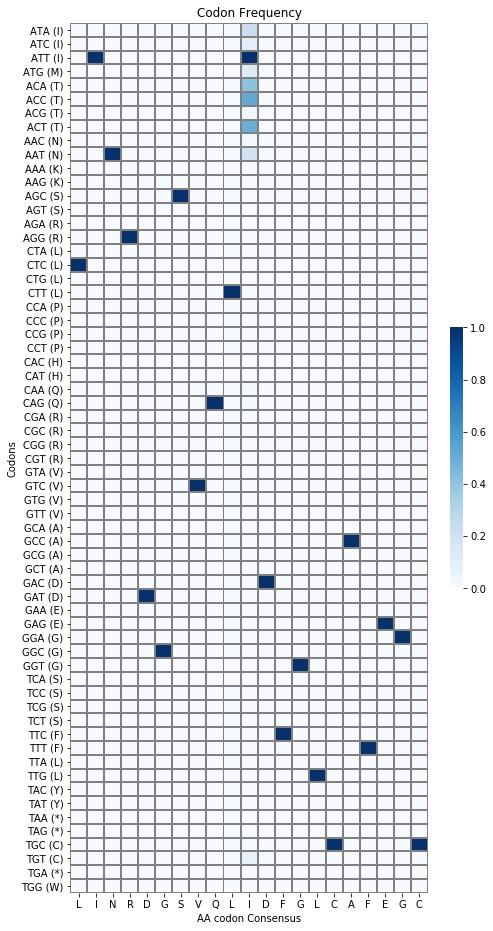

In [80]:
exp ='7-Amp'
temp = new_dict[exp]
temp = temp.drop('failed')
temp = temp.drop('GGG')
temp = (temp/temp.max())


labels = {}
for c in gencode:
    labels[c] = c+' ({})'.format(gencode[c])

labels2 = {}    
for n in temp:
    codon = temp[n].argmax()
    aa = gencode[codon]
    labels2[n] =aa

fig,ax=plt.subplots(figsize=(8,16))
print(exp)
sns.heatmap(temp.rename(labels).rename(labels2,axis=1),ax=ax,cmap='Blues',
            linewidths=1, linecolor='grey',cbar_kws={"shrink": .3})

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin+0.5,ymax-0.5)
ax.set_xlabel('AA codon Consensus')
ax.set_ylabel('Codons')
plt.title('Codon Frequency')
plt.show()

In [79]:
!tar -zcvf bam_counts.tar.gz bam_counts 

bam_counts/
bam_counts/10-Amp.csv
bam_counts/3-Amp.csv
bam_counts/9-Amp.csv
bam_counts/8-Amp.csv
bam_counts/5-Amp.csv
bam_counts/2-Amp.csv
bam_counts/7-Amp.csv
bam_counts/1-Amp.csv
bam_counts/6-Amp.csv


In [1]:
!jupyter nbconvert --to html bam_to_codon_counts.ipynb

[NbConvertApp] Converting notebook bam_to_codon_counts.ipynb to html
